Collaborators: Tom Resseguier, Swetha Sankar

In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp
from scipy.optimize import root
from matplotlib import pyplot as plt
import time

In [2]:
k = 1.381e-16
sigma = 5.670e-5
c = 2.998e10
a = 4 * sigma / c
G  = 6.674e-8
NA = 6.022e23

# Part 3

Note: I've chosen the Sun to be my star.

In [3]:
M_sol = 1.989e33
R_sol = 6.955e10
L_sol = 3.839e33

In [4]:
X = 0.7077
Z = 0.0188
Y = 1 - X - Z

In [5]:
excel_content = 'part2.xlsx'

In [6]:
# Using OPAL Table 73
df = pd.read_excel(excel_content, header=0, index_col=0)

In [7]:
opacity_table = df.to_numpy()
log_T = opacity_table[1:,0]
log_R = opacity_table[0,1:]
log_opacities = opacity_table[1:,1:]
print(log_T)
print(log_R)
print(log_opacities)

[3.75 3.8  3.85 3.9  3.95 4.   4.05 4.1  4.15 4.2  4.25 4.3  4.35 4.4
 4.45 4.5  4.55 4.6  4.65 4.7  4.75 4.8  4.85 4.9  4.95 5.   5.05 5.1
 5.15 5.2  5.25 5.3  5.35 5.4  5.45 5.5  5.55 5.6  5.65 5.7  5.75 5.8
 5.85 5.9  5.95 6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.
 7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.3  8.5  8.7 ]
[-8.  -7.5 -7.  -6.5 -6.  -5.5 -5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5
 -1.  -0.5  0.   0.5  1. ]
[[-0.767 -0.928 -1.119 ... -0.645 -0.261  0.131]
 [-0.561 -0.598 -0.675 ... -0.18   0.121  0.429]
 [-0.534 -0.53  -0.525 ...  0.384  0.628  0.894]
 ...
 [-0.633 -0.633 -0.633 ...    nan    nan    nan]
 [-0.704 -0.704 -0.704 ...    nan    nan    nan]
 [-0.582 -0.753 -0.785 ...    nan    nan    nan]]


In [8]:
interpolator = RegularGridInterpolator((log_T, log_R), log_opacities)

In [9]:
def interpolated_opacity(rho, T): 
        
    R = rho / (T * 10**-6)**3
    
    R = np.maximum(R, 10**-8)
    log_R = np.log10(R)
    
    T = np.maximum(T, 10**3.75)
    log_T = np.log10(T)

    #print('logR = ', log_R)
    #print('logT = ', log_T)
    
    point = [log_T, log_R]
    
    log_interpolated_value = interpolator(point)[0]
        
    opacity = 10**log_interpolated_value
    return opacity

# Part 4

In [10]:
def g11(T): 
    T9 = 1e-9 * T
    result = 1 + 3.82 * T9 + 1.51 * T9**2 + 0.144 * T9**3 - 0.0114 * T9**4
    return result

def get_eps_pp(rho, T): 
    T7 = 1e-7 * T
    T9 = 1e-9 * T
    psi = 1
    f11 = np.exp(5.92e-3 * rho**0.5 / T**1.5)
    result = 2.57 * 10**4 * psi * f11 * g11(T9) * rho * X**2 * (T9)**(-2/3) * np.exp(-3.381 / T9**(1/3))
    return result

def g141(T): 
    T9 = 1e-9 * T
    result = 1 - 2.00 * T9 + 3.41 * T9**2 - 2.43 * T9**3
    return result

def get_eps_CNO(rho, T):
    T9 = 1e-9 * T
    X_CNO = (0.173 + 0.053 + 0.482) * Z
    result = 8.24 * 10**25 * g141(T) * X_CNO * X * rho * T9**(-2/3) * np.exp(-15.231 * T9**(-1/3)-(T9/0.8)**2)
    return result

def get_eps(rho, T): 
    result = get_eps_pp(rho, T) + get_eps_CNO(rho, T)
    return result

# Part 5

Assuming complete ionization, and assuming Z << 1 (which is true for the Sun), we have:

$P = \frac{\rho N_A k T}{\mu} + \frac{a T^4}{3}$

i.e.

$\rho = \left[P - \frac{a T^4}{3}\right]\frac{\mu}{N_A k T}$

where $\mu = 4 / (3 + 5X)$.

In [11]:
mu = 4 / (3 + 5 * X)

In [12]:
def get_rho(P, T): 
    result = (P - a*T**4 / 3) * mu / (NA * k * T)
    return result

# Part 8

In [13]:
def load1(M_r, P_c, T_c):
    
    rho_c = get_rho(P_c, T_c)
    r = (3 * M_r / (4 * np.pi * rho_c))**(1/3)
    
    eps = get_eps(rho_c, T_c)
    l_r = eps * M_r
    
    P_r = P_c - 3 * G / (8 * np.pi) * (4 * np.pi / 3 * rho_c)**(4/3) * M_r**(2/3)    # from Session 18 lecture notes
    T_r = (T_c**4 - 1 / (2 * a * c) * (3 / (4 * np.pi))**(2/3) * interpolated_opacity(rho_c, T_c) * eps * rho_c**(4/3) * M_r**(2/3))**(1/4)    # Assuming a radiative core, which is true in the case of the Sun.
    
    result = (r, l_r, P_r, T_r)
    return result

def load2(R, L):
    
    T_eff = (L / (4 * np.pi * R**2 * sigma))**(1/4)
    
    def get_T(tau):
        result = T_eff * (3/4 * (tau + 2/3))**(1/4)
        return result

    def dP(tau, P):
        T = get_T(tau)
        rho = get_rho(P[0], T)
        result = G * M_sol / (R**2 * interpolated_opacity(rho, T))
        return result

    def get_P(tau):
        result = solve_ivp(dP, [0, tau], [0]).y[0][-1]
        return result
    
    tau_photosphere = 2/3
    T_R = get_T(tau_photosphere)
    P_R = get_P(tau_photosphere)
    
    result = (R, L, P_R, T_R)
    return result   

# Part 9

In [14]:
def get_del_rad(l, P, T, m):
    
    rho = get_rho(P, T)    
    result = 3 * P * interpolated_opacity(rho, T) * l / (16 * np.pi * a * c * T**4 * G * m)
    return result

def get_del_conv(P, T):
    
    rho = get_rho(P, T)    
    beta = rho * NA * k * T / (mu * P)
    result = (8 - 6 * beta) / (32 - 24 * beta - 3 * beta**2)
    return result

def nabla(l, P, T, m):
    
    del_ad = get_del_conv(P, T)
    del_rad = get_del_rad(l, P, T, m)
    
    if del_ad > del_rad: 
        result = (del_rad, True)
    else: 
        result = (del_ad, False)
        
    return result

def derivs(m, inp_fourvec):
    
    r = inp_fourvec[0]
    l = inp_fourvec[1]
    P = inp_fourvec[2]
    T = inp_fourvec[3]
    
    rho = get_rho(P, T)   
    
    true_del = nabla(l, P, T, m)[0]
    
    dr = 1 / (4 * np.pi * r**2 * rho)
    dl = get_eps(rho, T)
    dP = -G * m / (4 * np.pi * r**4)
    dT = -G * m * T / (4 * np.pi * r**4 * P) * true_del
    
    result = (dr, dl, dP, dT)
    return result

# Part 10

In [15]:
def newt(inp_fourvec):
    
    R = inp_fourvec[0]
    L = inp_fourvec[1]
    P_c = inp_fourvec[2]
    T_c = inp_fourvec[3]

    n_steps = 1000
    
    small_frac = 1e-10
    small_mass = small_frac * M_sol
    
    shooting_frac = 0.21
    shooting_mass = shooting_frac * M_sol
    
    out_eval = np.linspace(small_mass, shooting_mass, int(shooting_frac * n_steps))
    env_eval = M_sol - np.logspace(np.log10(small_mass), np.log10(shooting_mass / 2), int(shooting_frac * n_steps / 2))
    
    step = M_sol / n_steps
    
    switch = np.where(step < env_eval[:-1] - env_eval[1:])[0][0]
    SOROS = env_eval[switch]    # SOR stands for Start of Rest of Star
    NOSFROS = int((SOROS - shooting_mass) / step)    # NOSFROS stands for Number of Steps for Rest of Star
    
    ROS_eval = np.linspace(SOROS, shooting_mass, NOSFROS)    # ROS stands for Rest of Star
    env_eval = env_eval[:switch]
    in_eval = np.concatenate((env_eval, ROS_eval))    
    
    out_result = solve_ivp(derivs, [small_mass, shooting_mass], load1(small_mass, P_c, T_c), t_eval = out_eval)
    in_result = solve_ivp(derivs, [M_sol, shooting_mass], load2(R, L), t_eval = in_eval)
    
    result = (out_result, in_result)
    return result

In [16]:
P_c_sol = 2.65e17
T_c_sol = 1.5e7

initial_guess = [R_sol, L_sol, P_c_sol, T_c_sol]
print("INITIAL GUESS: ", initial_guess)

def get_scores(inp_fourvec):
    
    newt_result = newt(inp_fourvec)
    out_result = newt_result[0]
    in_result = newt_result[1]
    
    scores = []
    
    for index in range(4): 
        score = 2 * (out_result.y[index, -1] - in_result.y[index, -1]) / (out_result.y[index, -1] + in_result.y[index, -1])
        scores.append(score)
        
    return scores

start = time.time()
sol = root(get_scores, initial_guess)
end = time.time()
print('Total Computation Time: ', end - start, 'seconds')

newt_result = newt(sol.x)
out_result = newt_result[0]
in_result = newt_result[1]

newt_guess_result = newt(initial_guess)
out_guess_result = newt_guess_result[0]
in_guess_result = newt_guess_result[1]

INITIAL GUESS:  [69550000000.0, 3.839e+33, 2.65e+17, 15000000.0]
Total Computation Time:  3.332814931869507 seconds


In [17]:
#shooting_fraction = 0.21
#solve_ivp(derivs, [M_sol, shooting_fraction*M_sol], load2(initial_guess[0], initial_guess[1]))

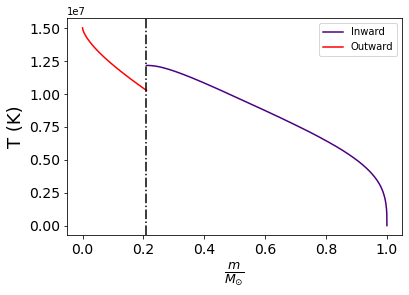

In [18]:
plt.plot(in_guess_result.t / M_sol, in_guess_result.y[3] , label='Inward', c='indigo')
plt.plot(out_guess_result.t / M_sol, out_guess_result.y[3], label='Outward', c='red')
plt.xlabel(r'$\frac{m}{M_{\odot}}$', fontsize=18)
plt.ylabel('T (K)', fontsize=18)
plt.legend()
plt.tick_params(axis='both', labelsize=14)
plt.axvline(x=0.21, linestyle='dashdot', c='black')

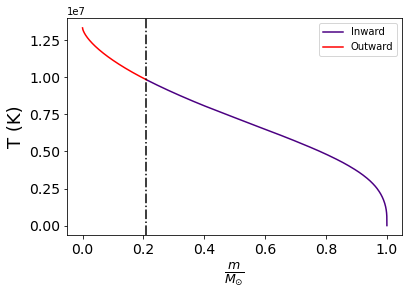

In [19]:
plt.plot(in_result.t / M_sol, in_result.y[3] , label='Inward', c='indigo')
plt.plot(out_result.t / M_sol, out_result.y[3], label='Outward', c='red')
plt.xlabel(r'$\frac{m}{M_{\odot}}$', fontsize=18)
plt.ylabel('T (K)', fontsize=18)
plt.legend()
plt.tick_params(axis='both', labelsize=14)
plt.axvline(x=0.21, linestyle='dashdot', c='black')

In [20]:
def plot_solns(inp_in_result, inp_out_result, c='blue'):
    
    in_yvals = [inp_in_result.y[0]/R_sol, inp_in_result.y[1]/L_sol, inp_in_result.y[2], inp_in_result.y[3]]
    out_yvals = [inp_out_result.y[0]/R_sol, inp_out_result.y[1]/L_sol, inp_out_result.y[2], inp_out_result.y[3]]
    
    labels = [r'$\frac{r}{R_{\odot}}$', r'$\frac{\ell}{L_{\odot}}$', 'P (dyne cm$^{-2}$)', 'T (K)']
    
    fig, ax = plt.subplots(4, 1, figsize=(6, 12), sharex=True)
    
    for index, subplot in enumerate(ax):
        
        subplot.plot(inp_out_result.t/M_sol, out_yvals[index], c=c)
        subplot.plot(inp_in_result.t/M_sol, in_yvals[index], c=c)
        subplot.set_ylabel(labels[index], fontsize=14)
        subplot.tick_params(axis='both', which='major', labelsize=14)
        
        if index == 3:
            plt.xlabel(r'$\frac{m}{M_{\odot}}$', fontsize=14)
    
    fig.canvas.draw()
    return fig, ax

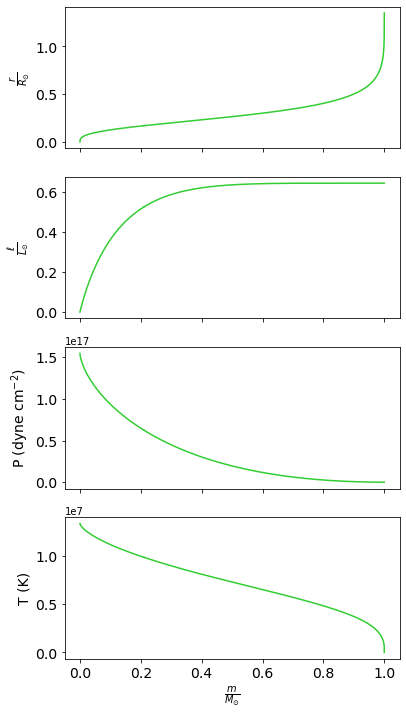

In [21]:
fig, ax = plot_solns(in_result, out_result, c='limegreen')

# Part 11 (MESA)

In [22]:
import mesa_reader as mr

# load entire LOG directory information
l = mr.MesaLogDir('mesa-r22.11.1/sun/LOGS/')
# grab the last profile
p = l.profile_data()

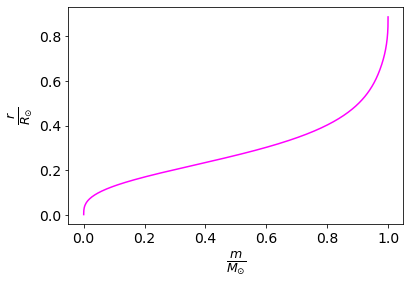

In [23]:
plt.plot(p.mass, p.R, c='magenta')
plt.xlabel(r'$\frac{m}{M_{\odot}}$', fontsize=18)
plt.ylabel(r'$\frac{r}{R_{\odot}}$', fontsize=18)
plt.tick_params(axis='both', labelsize=14)
plt.show()

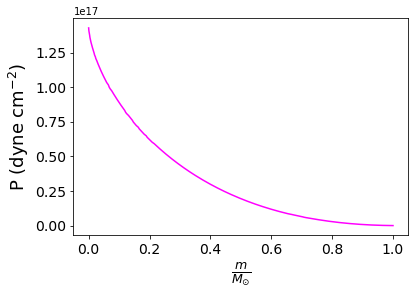

In [24]:
plt.plot(p.mass, p.P, c='magenta')
plt.xlabel(r'$\frac{m}{M_{\odot}}$', fontsize=18)
plt.ylabel('P (dyne cm$^{-2}$)', fontsize=18)
plt.tick_params(axis='both', labelsize=14)
plt.show()

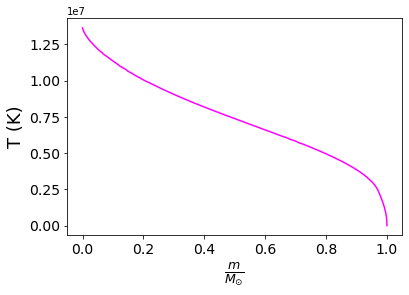

In [25]:
plt.plot(p.mass, p.T, c='magenta')
plt.xlabel(r'$\frac{m}{M_{\odot}}$', fontsize=18)
plt.ylabel('T (K)', fontsize=18)
plt.tick_params(axis='both', labelsize=14)
plt.show()

In [26]:
def plot_solns_MESA(inp_in_result, inp_out_result, c='blue', c_mesa='red'):
    
    in_yvals = [inp_in_result.y[0]/R_sol, inp_in_result.y[2], inp_in_result.y[3]]
    out_yvals = [inp_out_result.y[0]/R_sol, inp_out_result.y[2], inp_out_result.y[3]]
    
    labels = [r'$\frac{r}{R_{\odot}}$', 'P (dyne cm$^{-2}$)', 'T (K)']
    MESA_variables = [p.R, p.P, p.T]
    
    fig, ax = plt.subplots(3, 1, figsize=(6, 12), sharex=True)
    
    for index, subplot in enumerate(ax):
        
        subplot.plot(inp_out_result.t/M_sol, out_yvals[index], c=c)
        subplot.plot(inp_in_result.t/M_sol, in_yvals[index], c=c, label='shootf')
        subplot.plot(p.mass, MESA_variables[index], c=c_mesa, label='MESA')
        subplot.set_ylabel(labels[index], fontsize=14)
        subplot.tick_params(axis='both', which='major', labelsize=14)
        subplot.legend()
        
        if index == 2:
            plt.xlabel(r'$\frac{m}{M_{\odot}}$', fontsize=14)
    
    fig.canvas.draw()
    return fig, ax

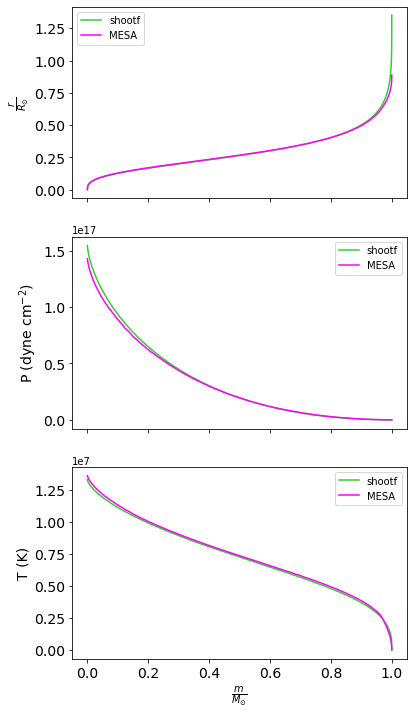

In [27]:
fig, ax = plot_solns_MESA(in_result, out_result, c='limegreen', c_mesa='magenta')

# Extra Code for the Write-Up

In [28]:
def get_shell_nature(l, P, T, m):
    is_rad = nabla(l, P, T, m)[1]
    return 'Rad' if is_rad else 'Conv'

masses = np.concatenate((out_result.t, in_result.t[::-1])).tolist()
radii = np.concatenate((out_result.y[0], in_result.y[0][::-1])).tolist()
luminosities = np.concatenate((out_result.y[1], in_result.y[1][::-1])).tolist()
pressures = np.concatenate((out_result.y[2], in_result.y[2][::-1])).tolist()
temperatures = np.concatenate((out_result.y[3], in_result.y[3][::-1])).tolist()

ln_T = np.log(temperatures)
ln_P = np.log(pressures)
dln_T = np.gradient(ln_T)
dln_P = np.gradient(ln_P)

temperature_gradients = dln_T / dln_P

rhos = []
epsilons = []
kappas = []
del_convs = []
shell_natures = []

num_points = len(masses)

for index in range(num_points): 
    rhos.append(get_rho(pressures[index], temperatures[index]))
    epsilons.append(get_eps(rhos[index], temperatures[index]))
    kappas.append(interpolated_opacity(rhos[index], temperatures[index]))
    del_convs.append(get_del_conv(pressures[index], temperatures[index]))
    shell_natures.append(get_shell_nature(luminosities[index], pressures[index], temperatures[index], masses[index]))

In [29]:
WU_num_points = 5

step_size = num_points // WU_num_points

def round_list(inp_list, sig_digits=3):
    def round_sci(x, sig_digits):
        return float(f"{x:.{sig_digits}e}")
    
    return [round_sci(x, sig_digits) for x in inp_list]

def TOSCI(inp_list):
    def to_sci_notation(x):
        return "{:.{}e}".format(x, 6)
    
    return [to_sci_notation(x) for x in inp_list]

WU_masses = round_list(masses[::step_size][:WU_num_points])    # WU stands for Write-Up (i.e. this is what's going to go in the write-up)
WU_radii = TOSCI(round_list(radii[::step_size][:WU_num_points]))
WU_luminosities = round_list(luminosities[::step_size][:WU_num_points])
WU_pressures = TOSCI(round_list(pressures[::step_size][:WU_num_points]))
WU_temperatures = TOSCI(round_list(temperatures[::step_size][:WU_num_points]))

WU_temperature_gradients = round_list(temperature_gradients[::step_size][:WU_num_points])

WU_kappas = round_list(kappas[::step_size][:WU_num_points])
WU_epsilons = round_list(epsilons[::step_size][:WU_num_points])
WU_rhos = round_list(rhos[::step_size][:WU_num_points])
WU_del_convs = round_list(del_convs[::step_size][:WU_num_points])
WU_shell_natures = shell_natures[::step_size][:WU_num_points]

In [30]:
def generate_latex_table(headers, *data):
    num_columns = len(headers)
    num_rows = len(data[0])

    # Begin the LaTeX table environment
    latex_table = "\\begin{table}\n\\centering\n\\begin{tabular}{|" + "c|" * (num_columns + 1) + "}\n\\hline\n"

    # Add an empty cell in the top-left corner
    latex_table += " & " + " & ".join(headers) + "\\\\ \\hline\n"

    # Add the data
    for i, var_name in enumerate(data):
        row_data = [str(value) for value in var_name[1]]
        latex_table += f"{var_name[0]} & " + " & ".join(row_data) + "\\\\ \\hline\n"

    # End the LaTeX table environment
    latex_table += "\\end{tabular}\n\\caption{Your table caption}\n\\label{your_table_label}\n\\end{table}"

    return latex_table

In [31]:
headers = ["Value 1", "Value 2", "Value 3", "Value 4", "Value 5"]
data1 = (r'$\frac{m}{M_{\odot}}$', WU_masses)
data2 = (r'$\frac{r}{R_{\odot}}$', WU_radii)
data3 = (r'$\frac{\ell}{L_{\odot}}$', WU_luminosities)
data4 = ('P', WU_pressures)
data5 = ('T', WU_temperatures)
data6 = ('Temperature Gradient', WU_temperature_gradients)
data7 = (r'$\kappa$', WU_kappas)
data8 = (r'$\varepsilon$', WU_epsilons)
data9 = (r'$\rho$', WU_rhos)
data10 = (r'$\nabla_{\text{conv}}$', WU_del_convs)
data11 = ('Shell Nature', WU_shell_natures)

latex_table = generate_latex_table(headers, data1, data2, data3, data4, data5, data6, data7, data8, data9, data10, data11)
print(latex_table)

\begin{table}
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
 & Value 1 & Value 2 & Value 3 & Value 4 & Value 5\\ \hline
$\frac{m}{M_{\odot}}$ & 1.989e+23 & 4.297e+32 & 8.602e+32 & 1.291e+33 & 1.721e+33\\ \hline
$\frac{r}{R_{\odot}}$ & 8.228000e+06 & 1.196000e+10 & 1.682000e+10 & 2.233000e+10 & 3.198000e+10\\ \hline
$\frac{\ell}{L_{\odot}}$ & 2.522e+24 & 2.04e+33 & 2.411e+33 & 2.472e+33 & 2.477e+33\\ \hline
P & 1.546000e+17 & 6.112000e+16 & 2.639000e+16 & 8.725000e+15 & 1.198000e+15\\ \hline
T & 1.333000e+07 & 9.772000e+06 & 7.817000e+06 & 6.111000e+06 & 4.141000e+06\\ \hline
Temperature Gradient & 0.3813 & 0.2923 & 0.24 & 0.207 & 0.1912\\ \hline
$\kappa$ & 1.564 & 2.33 & 3.092 & 4.389 & 8.25\\ \hline
$\varepsilon$ & 12.68 & 1.755 & 0.324 & 0.03761 & 0.0007628\\ \hline
$\rho$ & 85.23 & 45.99 & 24.82 & 10.5 & 2.127\\ \hline
$\nabla_{\text{conv}}$ & 0.3994 & 0.3995 & 0.3996 & 0.3995 & 0.3993\\ \hline
Shell Nature & Rad & Rad & Rad & Rad & Rad\\ \hline
\end{tabular}
\caption{Your table 